# sandboxRL: DDQN Atari | EPOCH Laboratory 2021

In [1]:
from baselines.common.atari_wrappers import make_atari, wrap_deepmind

import gym
import os, datetime, imageio, cv2

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

In [2]:
physical_devices = tf.config.experimental.list_physical_devices("GPU")
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
print("Version:", tf.__version__)
print("Eager mode:", tf.executing_eagerly())
print("GPU is", "available" if physical_devices else "NOT AVAILABLE")

Version: 2.4.1
Eager mode: True
GPU is available


## Build Environment

In [4]:
#print(gym.envs.registry.all())

In [5]:
ENV_NAME = "PongNoFrameskip-v4"
env = make_atari(ENV_NAME)

In [6]:
INPUT_SHAPE = (84, 84)
WINDOW_LENGTH = 4

In [7]:
# Warp the frames, grey scale, stake four frame and scale to smaller ratio
env = wrap_deepmind(env, frame_stack=True, scale=True)
env.seed(1)

/home/james/anaconda3/envs/gym/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


[1, 289714752]

In [8]:
screen_space = env.observation_space
num_states = env.observation_space.shape
action_space = env.action_space.n

print('Frame:', screen_space)
print('States:', num_states[0])
print('Actions:', action_space)

env.unwrapped.get_action_meanings()

Frame: Box(84, 84, 4)
States: 84
Actions: 6


['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']

In [9]:
# Random search of environment
#env.reset()
#for i in range(1000):
#    env.render()
#    action = np.random.choice(action_space)
#    new_frame, reward, terminal, info = env.step(action)
#    #print(reward, terminal, info['ale.lives'])

## Hyper-parameters

In [10]:
BATCH_SIZE = 32                                 # Size of batch taken from replay buffer
MAX_STEPS_PER_EPISODE = 18000                   # 5mins at 60fps = 18000 steps

In [11]:
MAX_MEMORY_LENGTH = 1000000                     # Maximum replay length
UPDATE_AFTER_ACTIONS = 4                        # Train the model after 4 actions

In [12]:
EPSILON_RANDOM_FRAMES = 50000                   # Number of frames to take random action and observe output
EPSILON_GREEDY_FRAMES = 1000000.0               # Number of frames for exploration

GAMMA = 0.99                                    # Discount factor for past rewards
EPSILON = 1.0                                   # Epsilon greedy parameter
EPSILON_MIN = 0.1                               # Minimum epsilon greedy parameter
EPSILON_MAX = 1.0                               # Maximum epsilon greedy parameter
EPSILON_ANNEALER = (EPSILON_MAX - EPSILON_MIN)  # Rate at which to reduce chance of random action being taken

In [13]:
UPDATE_TARGET_NETWORK = 10000                   # How often to update the target network
TAU = 0.08                                      # Dynamic update factor

In [14]:
DOUBLE = True                                   # Double DQN
DEULING = True                                  # Deuling DQN
PLAYBACK = False                                # Vizualize Training

## Create convolution model

In [15]:
def q_model():
    inputs = layers.Input(shape=(84, 84, 4,))

    layer1 = layers.Conv2D(32, 8, strides=4, activation="relu")(inputs)
    layer2 = layers.Conv2D(64, 4, strides=2, activation="relu")(layer1)
    layer3 = layers.Conv2D(64, 3, strides=1, activation="relu")(layer2)

    layer4 = layers.Flatten()(layer3)
    layer5 = layers.Dense(512, activation="relu", kernel_initializer='he_uniform')(layer4)
    
    if DEULING:
        value = layers.Dense(1, kernel_initializer='he_uniform')(layer5)
        value = layers.Lambda(lambda s: K.expand_dims(s[:, 0], -1), output_shape=(action_space,))(value)
        
        adv = layers.Dense(action_space, kernel_initializer='he_uniform')(layer5)
        adv = layers.Lambda(lambda a: a[:, :] - K.mean(a[:, :], keepdims=True), output_shape=(action_space,))(adv)
        
        action = layers.Add()([value, adv])
    else:
        action = layers.Dense(action_space, activation="linear", kernel_initializer='he_uniform')(layer5)

    return keras.Model(inputs=inputs, outputs=action)

In [16]:
# The first model makes the predictions for Q-values which are used to make a action.
model = q_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 84, 84, 4)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 20, 20, 32)   8224        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 9, 9, 64)     32832       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 7, 7, 64)     36928       conv2d_1[0][0]                   
______________________________________________________________________________________________

In [17]:
# Build a target model for the prediction of future rewards.
model_target = q_model()

In [18]:
# In the Deepmind paper they use RMSProp however then Adam optimizer improves training time
optimizer = keras.optimizers.Adam(learning_rate=0.00025, clipnorm=1.0)
#optimizer = keras.optimizers.RMSprop(learning_rate=0.00025, rho=0.95, epsilon=0.01 / 32**2)

## Train the network

In [19]:
def capture(step, sequence):
    if step < 600:
        frame = env.render(mode='rgb_array')
        sequence.append(frame)
    
    return sequence

In [20]:
def exploration(eps, nstate, step):
    if frame_count < EPSILON_RANDOM_FRAMES or eps > np.random.rand(1)[0]:
        action = np.random.choice(action_space)
    else:
        state_tensor = tf.convert_to_tensor(nstate)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model(state_tensor, training=False)
        action = tf.argmax(action_probs[0]).numpy()
    
    # NOOP - Fire on first frame of episode
    if step == 0:
        action = 1
        
    eps -= EPSILON_ANNEALER / EPSILON_GREEDY_FRAMES
    eps = max(eps, EPSILON_MIN)
    
    return action, eps

In [21]:
def step(naction):
    state_next, reward, terminal, info = env.step(naction)
    state_next = np.array(state_next)
    
    return state_next, reward, terminal, info

In [22]:
def punish(health, feedback):
    if info['ale.lives'] < health:
        life_lost = True
    else:
        life_lost = feedback
    health = info['ale.lives']
    
    return life_lost, health

In [23]:
def add_memory(naction, nstate, nstate_next, nterminal, nreward):
    action_history.append(naction)
    state_history.append(nstate)
    state_next_history.append(nstate_next)
    terminal_history.append(nterminal)
    rewards_history.append(nreward)

In [24]:
def sample(memory):
    indices = np.random.choice(range(len(memory)), size=BATCH_SIZE)

    state_sample = np.array([state_history[i] for i in indices])
    state_next_sample = np.array([state_next_history[i] for i in indices])
    rewards_sample = [rewards_history[i] for i in indices]
    action_sample = [action_history[i] for i in indices]
    terminal_sample = tf.convert_to_tensor([float(memory[i]) for i in indices])
    
    return state_sample, state_next_sample, rewards_sample, action_sample, terminal_sample

In [25]:
@tf.function
def update_target(target_weights, weights, ratio, dynamic):
    if dynamic:
        for (a, b) in zip(target_weights, weights):
            a.assign(b * ratio + a * (1 - ratio))
    else:
        if frame_count % UPDATE_TARGET_NETWORK == 0:
            model_target.set_weights(model.get_weights())

In [26]:
def evaluate(episode_id, instance):
    state = np.array(env.reset())
    
    episode_reward = 0
    frames = []

    for timestep in range(1, MAX_STEPS_PER_EPISODE):

        # Capture gameplay experience
        frames = capture(timestep, frames)

        # Predict action Q-values from environment state and take best action
        state_tensor = tf.convert_to_tensor(state)
        state_tensor = tf.expand_dims(state_tensor, 0)
        action_probs = model(state_tensor, training=False)
        action = tf.argmax(action_probs[0]).numpy()

        # Apply the sampled action in our environment
        state_next, reward, terminal, _ = env.step(action)
        state = np.array(state_next)

        episode_reward += reward

        if terminal:
            break
            
    render_gif(frames, log_dir + timestamp + "/" + instance + "_" + str(episode_id) + "_" + str(episode_reward))

    return episode_reward

In [27]:
def render_gif(frames, filename):   
    return imageio.mimsave(filename + '.gif', frames)

In [28]:
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
print("ID:", timestamp)

ID: 20210705-200405


In [29]:
log_dir = "logs/fit/"
summary_writer = tf.summary.create_file_writer(log_dir + timestamp)

In [30]:
command = "tensorboard --logdir=" + str(log_dir) + " --port=6006 &"
os.system(command)

tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
checkpoint = tf.train.Checkpoint(model)
checkpoint_path = "training_checkpoints/" + timestamp + "/training_checkpoints"

In [32]:
# Experience replay buffers
action_history = []
state_history = []
state_next_history = []
rewards_history = []
terminal_history = []
episode_reward_history = []

In [33]:
running_reward = 0
episode_count = 0
frame_count = 0

In [34]:
min_reward = -21
eval_reward = -21

In [35]:
while True:  # Run until solved
    state = np.array(env.reset())
    episode_reward = 0
    
    terminal_life_lost = True
    life = 0

    for timestep in range(1, MAX_STEPS_PER_EPISODE):
        
        if PLAYBACK:
            env.render();                                                    # View training in real-time
        
        frame_count += 1
                    
        action, EPSILON = exploration(EPSILON, state, timestep)              # Use epsilon-greedy for exploration

        state_next, reward, terminal, info = step(action)                    # Apply the sampled action in our environment       
        terminal_life_lost, life = punish(life, terminal)                    # Punishment for points lost within before terminal state
        
        add_memory(action, state, state_next, terminal_life_lost, reward)    # Save actions and states in replay buffer
        
        episode_reward += reward                                             # Update running reward
        state = state_next                                                   # Update state

        #############
        ### TRAIN ###
        #############
        # Update every fourth frame and once batch size is over 32
        if frame_count % UPDATE_AFTER_ACTIONS == 0 and len(terminal_history) > BATCH_SIZE:

            # Sample from replay buffer
            state_sample, state_next_sample, rewards_sample, action_sample, terminal_sample = sample(terminal_history)
            
            # Double Q-Learning, decoupling selection and evaluation of the action seletion with the current DQN model.
            q = model.predict(state_next_sample)
            target_q = model_target.predict(state_next_sample)
            
            # Build the updated Q-values for the sampled future states - DQN / DDQN
            if DOUBLE:
                max_q = tf.argmax(q, axis=1)
                max_actions = tf.one_hot(max_q, action_space)
                q_samp = rewards_sample + GAMMA * tf.reduce_sum(tf.multiply(target_q, max_actions), axis=1)
            else:
                q_samp = rewards_sample + GAMMA * tf.reduce_max(target_q, axis=1)        # Bellman Equation
          
            q_samp = q_samp * (1 - terminal_sample) - terminal_sample                    # If final frame set the last value to -1
            masks = tf.one_hot(action_sample, action_space)                              # Create a mask so we only calculate loss on the updated Q-values

            with tf.GradientTape() as tape:
                q_values = model(state_sample)                                           # Train the model on the states and updated Q-values
                q_action = tf.reduce_sum(tf.multiply(q_values, masks), axis=1)           # Apply the masks to the Q-values to get the Q-value for action taken
                loss = keras.losses.Huber()(q_samp, q_action)                              # Calculate loss between new Q-value and old Q-value

            # Backpropagation
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Update the the target network with new weights
        update_target(model_target.trainable_variables, model.trainable_variables, TAU, True)
        
        # Limit the state and reward history
        if len(rewards_history) > MAX_MEMORY_LENGTH:
            del rewards_history[:1]
            del state_history[:1]
            del state_next_history[:1]
            del action_history[:1]
            del terminal_history[:1]

        # Log details
        if frame_count % MAX_STEPS_PER_EPISODE == 0:
            template = "running reward: {:.2f} at episode {}, frame count {}"
            print(template.format(running_reward, episode_count, frame_count))

        if terminal:
            break

    # Update running reward to check condition for solving
    episode_reward_history.append(episode_reward)
    if len(episode_reward_history) > 100:
        del episode_reward_history[:1]
    running_reward = np.mean(episode_reward_history)
            
    ############
    ### TEST ###
    ############
    # If running_reward has improved by factor of N; evalute & render without epsilon annealer.
    if running_reward > min_reward:  
        checkpoint.save(checkpoint_path)
        eval_reward = evaluate(episode_count, "pong_DQN_test")
        min_reward = running_reward + 1
    
    # Callbacks
    with summary_writer.as_default():
        tf.summary.scalar('running_reward', running_reward, step=episode_count)
        tf.summary.scalar('eval_reward', eval_reward, step=episode_count)

    # Condition to consider the task solved (Pong = 21 | Breakout = 40)
    if running_reward == 21:
        checkpoint.save(checkpoint_path)
        print("Solved at episode {}!".format(episode_count))
        break
        
    episode_count += 1
    
env.close()

running reward: -20.37 at episode 19, frame count 18000
running reward: -20.18 at episode 38, frame count 36000
running reward: -20.26 at episode 57, frame count 54000
running reward: -20.23 at episode 77, frame count 72000
running reward: -20.19 at episode 95, frame count 90000
running reward: -20.11 at episode 113, frame count 108000
running reward: -20.06 at episode 130, frame count 126000
running reward: -20.00 at episode 146, frame count 144000
running reward: -19.86 at episode 163, frame count 162000
running reward: -19.75 at episode 179, frame count 180000
running reward: -19.67 at episode 195, frame count 198000
running reward: -19.59 at episode 211, frame count 216000
running reward: -19.48 at episode 226, frame count 234000
running reward: -19.35 at episode 240, frame count 252000
running reward: -19.32 at episode 257, frame count 270000
running reward: -19.24 at episode 272, frame count 288000
running reward: -19.20 at episode 286, frame count 306000
running reward: -19.18 a

KeyboardInterrupt: 

## Validate training and callbacks

In [ ]:
load = tf.train.latest_checkpoint("training_checkpoints/20210608-024241/training_checkpoints-28.index")

#latest = tf.train.latest_checkpoint(checkpoint_path)
checkpoint.restore(load)

## Inference

In [36]:
nb_episodes = 5

In [37]:
print("Testing for " + str(nb_episodes) + " episodes ...")

episode_reward = 0
episode_count = 0
for i in range(nb_episodes):
    episode_reward = evaluate(episode_count, "pong_DQN_infer")
    print("Episode " + str(episode_count+1) + ": Reward: " + str(episode_reward))
    episode_count += 1

Testing for 5 episodes ...
Episode 1: Reward: -12.0
Episode 2: Reward: -19.0
Episode 3: Reward: -20.0
Episode 4: Reward: -18.0
Episode 5: Reward: -15.0


## Vizualization

In [38]:
state = env.reset()
dimensions = (210, 160)

In [39]:
def viewslice(state, count):
    frame = np.array(state)
    frame = processed_frame = np.repeat(frame[:, :, count, np.newaxis], 3, axis=2)
    frame = cv2.resize(frame, dsize=(dimensions[1], dimensions[0]))

    return frame

In [40]:
def generate_heatmap(frame, model):
    with tf.GradientTape() as tape:
        last_conv_layer = model.get_layer('conv2d_2')
        iterate = tf.keras.models.Model([model.inputs], [model.output, last_conv_layer.output])
        model_out, last_conv_layer = iterate(frame[np.newaxis, :, :, :])
        class_out = model_out[:, np.argmax(model_out[0])]
        grads = tape.gradient(class_out, last_conv_layer)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    heatmap = heatmap.reshape((7, 7))
    heatmap = cv2.resize(heatmap, (INPUT_SHAPE[1], INPUT_SHAPE[0]))
    heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET) / 255
    
    processed_frame = np.repeat(frame[:, :, 3, np.newaxis], 3, axis=2)
    combined_frame = cv2.resize(heatmap * processed_frame, dsize=(dimensions[1], dimensions[0]))

    return combined_frame

IndexError: index 4 is out of bounds for axis 2 with size 4

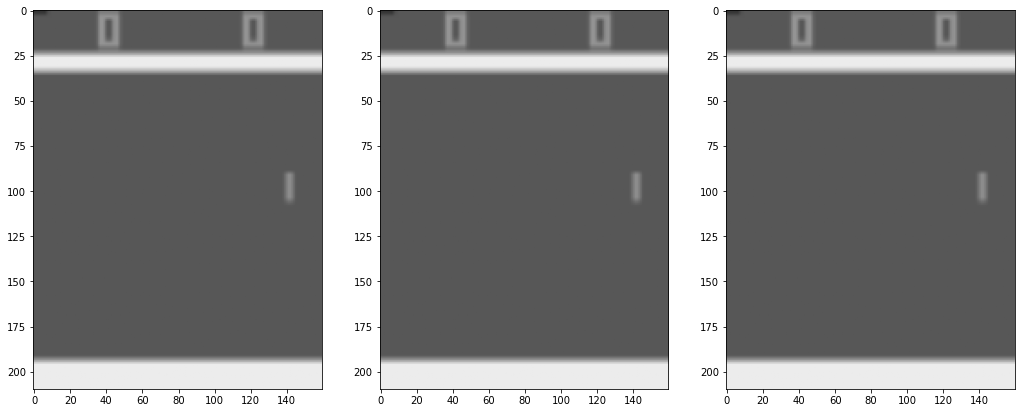

In [41]:
nplot = 4

fig = plt.figure(figsize=(30,30))
for count in range(1,nplot+1):
    frame = viewslice(state, count)
    ax = fig.add_subplot(1,nplot+1,count)
    ax.imshow(frame)

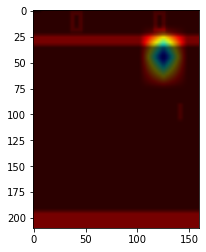

In [42]:
plt.imshow(generate_heatmap(state, model))

In [43]:
min_q_val = -0.1
max_q_val = 0.1

action_titles = []
q_vals = [0]*env.action_space.n

for i, (q_val, label) in enumerate(zip(q_vals[::-1], action_titles[::-1])):
    if qval > max_q_val:
        max_q_val = q_val
    elif q_val < min_q_val:
        min_q_val = q_val
    
print(max_q_val)  

0.1


In [48]:
values = []

dpi_res = min(84, 84) / 10
fig = plt.Figure((500 / dpi_res, 230 / dpi_res), dpi=dpi_res)
ax = fig.add_subplot(111)

# Set up plot
ax.set_title('Estimated Value over Time', fontsize=20)
ax.set_xticklabels([])
ax.set_ylabel('V(s)')
ax.plot(values[max(len(values)-200, 0):])  # plot values

plt.show()